# Colab FAQ

For some basic overview and features offered in Colab notebooks, check out: [Overview of Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

You need to use the colab GPU for this assignmentby selecting:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

# Download CIFAR and Colour dictionary
It can take up to a couple of minutes to download everything the first time.

## Helper code
You can ignore the restart warning.

In [2]:
######################################################################
# Setup python environment and change the current working directory
######################################################################
!pip install torch torchvision
!pip install Pillow==4.0.0
%mkdir -p /content/cs6360/a2/
%cd /content/cs6360/a2

    100% |████████████████████████████████| 5.6MB 6.5MB/s 
fastai 0.7.0 has requirement torch<0.4, but you'll have torch 1.0.1.post2 which is incompatible.
scikit-image 0.14.2 has requirement pillow>=4.3.0, but you'll have pillow 4.0.0 which is incompatible.
torchvision 0.2.2.post3 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 4.3.0
    Uninstalling Pillow-4.3.0:
      Successfully uninstalled Pillow-4.3.0


/content/cs6360/a2


In [0]:
# adapted from 
# https://github.com/fchollet/keras/blob/master/keras/datasets/cifar10.py

import os
from six.moves.urllib.request import urlretrieve
import tarfile
import numpy as np
import pickle
import sys
from PIL import Image


def get_file(fname,
             origin,
             untar=False,
             extract=False,
             archive_format='auto',
             cache_dir='data'):
    datadir = os.path.join(cache_dir)
    if not os.path.exists(datadir):
        os.makedirs(datadir)

    if untar:
        untar_fpath = os.path.join(datadir, fname)
        fpath = untar_fpath + '.tar.gz'
    else:
        fpath = os.path.join(datadir, fname)
    
    print(fpath)
    if not os.path.exists(fpath):
        print('Downloading data from', origin)

        error_msg = 'URL fetch failure on {}: {} -- {}'
        try:
            try:
                urlretrieve(origin, fpath)
            except URLError as e:
                raise Exception(error_msg.format(origin, e.errno, e.reason))
            except HTTPError as e:
                raise Exception(error_msg.format(origin, e.code, e.msg))
        except (Exception, KeyboardInterrupt) as e:
            if os.path.exists(fpath):
                os.remove(fpath)
            raise

    if untar:
        if not os.path.exists(untar_fpath):
            print('Extracting file.')
            with tarfile.open(fpath) as archive:
                archive.extractall(datadir)
        return untar_fpath

    if extract:
        _extract_archive(fpath, datadir, archive_format)

    return fpath



def load_batch(fpath, label_key='labels'):
    """Internal utility for parsing CIFAR data.
    # Arguments
        fpath: path the file to parse.
        label_key: key for label data in the retrieve
            dictionary.
    # Returns
        A tuple `(data, labels)`.
    """
    f = open(fpath, 'rb')
    if sys.version_info < (3,):
        d = pickle.load(f)
    else:
        d = pickle.load(f, encoding='bytes')
        # decode utf8
        d_decoded = {}
        for k, v in d.items():
            d_decoded[k.decode('utf8')] = v
        d = d_decoded
    f.close()
    data = d['data']
    labels = d[label_key]

    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels

def load_cifar10(transpose=False):
    """Loads CIFAR10 dataset.
    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    dirname = 'cifar-10-batches-py'
    origin = 'http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
    path = get_file(dirname, origin=origin, untar=True)

    num_train_samples = 50000

    x_train = np.zeros((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train = np.zeros((num_train_samples,), dtype='uint8')

    for i in range(1, 6):
        fpath = os.path.join(path, 'data_batch_' + str(i))
        data, labels = load_batch(fpath)
        x_train[(i - 1) * 10000: i * 10000, :, :, :] = data
        y_train[(i - 1) * 10000: i * 10000] = labels

    fpath = os.path.join(path, 'test_batch')
    x_test, y_test = load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if transpose:
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)
    return (x_train, y_train), (x_test, y_test)


## Download files

This may take 1 or 2 mins for the first time.

In [4]:
######################################################################
# Download CIFAR datasets and other related files
######################################################################
colours_fpath = get_file(fname='colours', 
                         origin='http://www.cs.toronto.edu/~jba/kmeans_colour_a2.tar.gz', 
                         untar=True)
m = load_cifar10()

data/colours.tar.gz
('Downloading data from', 'http://www.cs.toronto.edu/~jba/kmeans_colour_a2.tar.gz')
Extracting file.
data/cifar-10-batches-py.tar.gz
('Downloading data from', 'http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz')
Extracting file.


# Code for training and CNN models

## Data preprocessing

In [0]:
"""
Colourization of CIFAR-10 Horses via classification.
"""
from __future__ import print_function
import argparse
import math
import numpy as np
import numpy.random as npr
import scipy.misc
import time
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib
import matplotlib.pyplot as plt 


#from load_data import load_cifar10

HORSE_CATEGORY = 7

######################################################################
# Data related code
######################################################################
def get_rgb_cat(xs, colours):
    """
    Get colour categories given RGB values. This function doesn't
    actually do the work, instead it splits the work into smaller
    chunks that can fit into memory, and calls helper function
    _get_rgb_cat

    Args:
      xs: float numpy array of RGB images in [B, C, H, W] format
      colours: numpy array of colour categories and their RGB values
    Returns:
      result: int numpy array of shape [B, 1, H, W]
    """
    if np.shape(xs)[0] < 100:
        return _get_rgb_cat(xs)
    batch_size = 100
    nexts = []
    for i in range(0, np.shape(xs)[0], batch_size):
        next = _get_rgb_cat(xs[i:i+batch_size,:,:,:], colours)
        nexts.append(next)
    result = np.concatenate(nexts, axis=0)
    return result

def _get_rgb_cat(xs, colours):
    """
    Get colour categories given RGB values. This is done by choosing
    the colour in `colours` that is the closest (in RGB space) to
    each point in the image `xs`. This function is a little memory
    intensive, and so the size of `xs` should not be too large.

    Args:
      xs: float numpy array of RGB images in [B, C, H, W] format
      colours: numpy array of colour categories and their RGB values
    Returns:
      result: int numpy array of shape [B, 1, H, W]
    """
    num_colours = np.shape(colours)[0]
    xs = np.expand_dims(xs, 0)
    cs = np.reshape(colours, [num_colours,1,3,1,1])
    dists = np.linalg.norm(xs-cs, axis=2) # 2 = colour axis
    cat = np.argmin(dists, axis=0)
    cat = np.expand_dims(cat, axis=1)
    return cat

def get_cat_rgb(cats, colours):
    """
    Get RGB colours given the colour categories

    Args:
      cats: integer numpy array of colour categories
      colours: numpy array of colour categories and their RGB values
    Returns:
      numpy tensor of RGB colours
    """
    return colours[cats]

def process(xs, ys, max_pixel=256.0, downsize_input=False):
    """
    Pre-process CIFAR10 images by taking only the horse category,
    shuffling, and have colour values be bound between 0 and 1

    Args:
      xs: the colour RGB pixel values
      ys: the category labels
      max_pixel: maximum pixel value in the original data
    Returns:
      xs: value normalized and shuffled colour images
      grey: greyscale images, also normalized so values are between 0 and 1
    """
    xs = xs / max_pixel
    xs = xs[np.where(ys == HORSE_CATEGORY)[0], :, :, :]
    npr.shuffle(xs)
    
    grey = np.mean(xs, axis=1, keepdims=True)

    if downsize_input:
      downsize_module = nn.Sequential(nn.AvgPool2d(2),
                               nn.AvgPool2d(2), 
                               nn.Upsample(scale_factor=2), 
                               nn.Upsample(scale_factor=2))
      xs_downsized = downsize_module.forward(torch.from_numpy(xs).float())
      xs_downsized = xs_downsized.data.numpy()
      #print(xs_downsized.shape)
      return (xs, xs_downsized)
    else:
      return (xs, grey)


def get_batch(x, y, batch_size):
    '''
    Generated that yields batches of data

    Args:
      x: input values
      y: output values
      batch_size: size of each batch
    Yields:
      batch_x: a batch of inputs of size at most batch_size
      batch_y: a batch of outputs of size at most batch_size
    '''
    N = np.shape(x)[0]
    assert N == np.shape(y)[0]
    for i in range(0, N, batch_size):
        batch_x = x[i:i+batch_size, :,:,:]
        batch_y = y[i:i+batch_size, :,:,:]
        yield (batch_x, batch_y)

######################################################################
# Torch Helper
######################################################################

def get_torch_vars(xs, ys, gpu=False):
    """
    Helper function to convert numpy arrays to pytorch tensors.
    If GPU is used, move the tensors to GPU.

    Args:
      xs (float numpy tenosor): greyscale input
      ys (int numpy tenosor): categorical labels 
      gpu (bool): whether to move pytorch tensor to GPU
    Returns:
      Variable(xs), Variable(ys)
    """
    xs = torch.from_numpy(xs).float()
    ys = torch.from_numpy(ys).long()
    if gpu:
        xs = xs.cuda()
        ys = ys.cuda()
    return Variable(xs), Variable(ys)

def compute_loss(criterion, outputs, labels, batch_size, num_colours):
    """
    Helper function to compute the loss. Since this is a pixelwise
    prediction task we need to reshape the output and ground truth
    tensors into a 2D tensor before passing it in to the loss criteron.

    Args:
      criterion: pytorch loss criterion
      outputs (pytorch tensor): predicted labels from the model
      labels (pytorch tensor): ground truth labels
      batch_size (int): batch size used for training
      num_colours (int): number of colour categories
    Returns:
      pytorch tensor for loss
    """

    loss_out = outputs.transpose(1,3) \
                      .contiguous() \
                      .view([batch_size*32*32, num_colours])
    loss_lab = labels.transpose(1,3) \
                      .contiguous() \
                      .view([batch_size*32*32])
    return criterion(loss_out, loss_lab)

def run_validation_step(cnn, criterion, test_grey, test_rgb_cat, batch_size,
                        colours, plotpath=None, visualize=True, downsize_input=False):
    correct = 0.0
    total = 0.0
    losses = []
    num_colours = np.shape(colours)[0]
    for i, (xs, ys) in enumerate(get_batch(test_grey,
                                           test_rgb_cat,
                                           batch_size)):
        images, labels = get_torch_vars(xs, ys, args.gpu)
        outputs = cnn(images)

        val_loss = compute_loss(criterion,
                                outputs,
                                labels,
                                batch_size=args.batch_size,
                                num_colours=num_colours)
        losses.append(val_loss.data.item())

        _, predicted = torch.max(outputs.data, 1, keepdim=True)
        total += labels.size(0) * 32 * 32
        correct += (predicted == labels.data).sum()

    if plotpath: # only plot if a path is provided
        plot(xs, ys, predicted.cpu().numpy(), colours, 
             plotpath, visualize=visualize, compare_bilinear=downsize_input)

    val_loss = np.mean(losses)
    val_acc = 100 * correct / total
    return val_loss, val_acc


## Visualization

In [0]:
def plot(input, gtlabel, output, colours, path, visualize, compare_bilinear=False):
    """
    Generate png plots of input, ground truth, and outputs

    Args:
      input: the greyscale input to the colourization CNN
      gtlabel: the grouth truth categories for each pixel
      output: the predicted categories for each pixel
      colours: numpy array of colour categories and their RGB values
      path: output path
      visualize: display the figures inline or save the figures in path
    """
    
    grey = np.transpose(input[:10,:,:,:], [0,2,3,1])
    gtcolor = get_cat_rgb(gtlabel[:10,0,:,:], colours)
    predcolor = get_cat_rgb(output[:10,0,:,:], colours)

    img_stack = [
      np.hstack(np.tile(grey, [1,1,1,3])),
      np.hstack(gtcolor),
      np.hstack(predcolor)]
    
    if compare_bilinear:
      downsize_module = nn.Sequential(nn.AvgPool2d(2),
                                 nn.AvgPool2d(2), 
                                 nn.Upsample(scale_factor=2, mode='bilinear'), 
                                 nn.Upsample(scale_factor=2, mode='bilinear'))
      gt_input = np.transpose(gtcolor, [0, 3, 1, 2,])
      color_bilinear = downsize_module.forward(torch.from_numpy(gt_input).float())
      color_bilinear = np.transpose(color_bilinear.data.numpy(), [0, 2, 3, 1])
      img_stack = [
        np.hstack(np.transpose(input[:10,:,:,:], [0,2,3,1])),
        np.hstack(gtcolor),
        np.hstack(predcolor),
        np.hstack(color_bilinear)]
    img = np.vstack(img_stack)
    
    plt.grid('off')
    plt.imshow(img, vmin=0., vmax=1.)
    if visualize:
      plt.show()
    else:
      plt.savefig(path)

def toimage(img, cmin, cmax):
    return Image.fromarray((img.clip(cmin, cmax)*255).astype(np.uint8))
  
def plot_activation(args, cnn):
    # LOAD THE COLOURS CATEGORIES
    colours = np.load(args.colours, allow_pickle=True)[0]
    num_colours = np.shape(colours)[0]
    
    (x_train, y_train), (x_test, y_test) = load_cifar10()
    test_rgb, test_grey = process(x_test, y_test, downsize_input = args.downsize_input)
    test_rgb_cat = get_rgb_cat(test_rgb, colours)
    
    # Take the idnex of the test image
    id = args.index
    outdir = "outputs/" + args.experiment_name + '/act' + str(id)
    if not os.path.exists(outdir):
      os.makedirs(outdir)
    images, labels = get_torch_vars(np.expand_dims(test_grey[id], 0),
                                    np.expand_dims(test_rgb_cat[id], 0))
    cnn.cpu()
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1, keepdim=True)
    predcolor = get_cat_rgb(predicted.cpu().numpy()[0,0,:,:], colours)
    img = predcolor
    toimage(predcolor, cmin=0, cmax=1) \
            .save(os.path.join(outdir, "output_%d.png" % id))

    if not args.downsize_input:
      img = np.tile(np.transpose(test_grey[id], [1,2,0]), [1,1,3])
    else:
      img = np.transpose(test_grey[id], [1,2,0])
    toimage(img, cmin=0, cmax=1) \
            .save(os.path.join(outdir, "input_%d.png" % id))

    img = np.transpose(test_rgb[id], [1,2,0])
    toimage(img, cmin=0, cmax=1) \
            .save(os.path.join(outdir, "input_%d_gt.png" % id))

    
    def add_border(img):
        return np.pad(img, 1, "constant", constant_values=1.0)

    def draw_activations(path, activation, imgwidth=4):
        img = np.vstack([
            np.hstack([
                add_border(filter) for filter in
                activation[i*imgwidth:(i+1)*imgwidth,:,:]])
            for i in range(activation.shape[0] // imgwidth)])
        scipy.misc.imsave(path, img)


    for i, tensor in enumerate([cnn.out1, cnn.out2, cnn.out3, cnn.out4, cnn.out5]):
        draw_activations(
            os.path.join(outdir, "conv%d_out_%d.png" % (i+1, id)),
            tensor.data.cpu().numpy()[0])
    print("visualization results are saved to %s"%outdir)

## Training

In [0]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def train(args, cnn=None):
    # Set the maximum number of threads to prevent crash in Teaching Labs
    torch.set_num_threads(5)
    # Numpy random seed
    npr.seed(args.seed)
    
    # Save directory
    save_dir = "outputs/" + args.experiment_name

    # LOAD THE COLOURS CATEGORIES
    colours = np.load(args.colours,allow_pickle=True)[0]
    num_colours = np.shape(colours)[0]
    # INPUT CHANNEL
    num_in_channels = 1 if not args.downsize_input else 3
    # LOAD THE MODEL
    if cnn is None:
      if args.model == "CNN":
          cnn = CNN(args.kernel, args.num_filters, num_colours, num_in_channels)
      elif args.model == "UNet":
          cnn = UNet(args.kernel, args.num_filters, num_colours, num_in_channels)

    # LOSS FUNCTION
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(cnn.parameters(), lr=args.learn_rate)

    # DATA
    print("Loading data...")
    (x_train, y_train), (x_test, y_test) = load_cifar10()

    print("Transforming data...")
    train_rgb, train_grey = process(x_train, y_train, downsize_input = args.downsize_input)
    train_rgb_cat = get_rgb_cat(train_rgb, colours)
    #print(train_rgb.size)
    #print (train_rgb_cat.size)
    test_rgb, test_grey = process(x_test, y_test, downsize_input = args.downsize_input)
    test_rgb_cat = get_rgb_cat(test_rgb, colours)

    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...")
    if args.gpu: cnn.cuda()
    start = time.time()

    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(args.epochs):
        # Train the Model
        cnn.train() # Change model to 'train' mode
        losses = []
        for i, (xs, ys) in enumerate(get_batch(train_grey,
                                               train_rgb_cat,
                                               args.batch_size)):
            images, labels = get_torch_vars(xs, ys, args.gpu)
            #print(images.size())
            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = cnn(images)

            loss = compute_loss(criterion,
                                outputs,
                                labels,
                                batch_size=args.batch_size,
                                num_colours=num_colours)
            loss.backward()
            optimizer.step()
            losses.append(loss.data.item())

        # plot training images
        if args.plot:
            _, predicted = torch.max(outputs.data, 1, keepdim=True)
            plot(xs, ys, predicted.cpu().numpy(), colours,
                 save_dir+'/train_%d.png' % epoch, 
                 args.visualize, 
                 args.downsize_input)

        # plot training images
        avg_loss = np.mean(losses)
        train_losses.append(avg_loss)
        time_elapsed = time.time() - start
        print('Epoch [%d/%d], Loss: %.4f, Time (s): %d' % (
            epoch+1, args.epochs, avg_loss, time_elapsed))

        # Evaluate the model
        cnn.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
        val_loss, val_acc = run_validation_step(cnn,
                                                criterion,
                                                test_grey,
                                                test_rgb_cat,
                                                args.batch_size,
                                                colours,
                                                save_dir+'/test_%d.png' % epoch,
                                                args.visualize,
                                                args.downsize_input)

        time_elapsed = time.time() - start
        valid_losses.append(val_loss)
        valid_accs.append(val_acc)
        print('Epoch [%d/%d], Val Loss: %.4f, Val Acc: %.1f%%, Time(s): %d' % (
            epoch+1, args.epochs, val_loss, val_acc, time_elapsed))
    
    # Plot training curve
    plt.figure()
    plt.plot(train_losses, "ro-", label="Train")
    plt.plot(valid_losses, "go-", label="Validation")
    plt.legend()
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.savefig(save_dir+"/training_curve.png")

    if args.checkpoint:
        print('Saving model...')
        torch.save(cnn.state_dict(), args.checkpoint)
    
    return cnn

## Convolutional neural networks (your code goes here)

In [0]:
######################################################################
# MODELS
######################################################################

class MyConv2d(nn.Module):
    """
    Our simplified implemented of nn.Conv2d module for 2D convolution
    """
    def __init__(self, in_channels, out_channels, kernel_size, padding=None):
        super(MyConv2d, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        if padding is None:
            self.padding = kernel_size // 2
        else:
            self.padding = padding
        self.weight = nn.parameter.Parameter(torch.Tensor(
            out_channels, in_channels, kernel_size, kernel_size))
        self.bias = nn.parameter.Parameter(torch.Tensor(out_channels))
        self.reset_parameters()

    def reset_parameters(self):
        n = self.in_channels * self.kernel_size * self.kernel_size
        stdv = 1. / math.sqrt(n)
        self.weight.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input):
        return F.conv2d(input, self.weight, self.bias, padding=self.padding)


class CNN(nn.Module):
    def __init__(self, kernel, num_filters, num_colours, num_in_channels):
        super(CNN, self).__init__()
        padding = kernel // 2

        ############### YOUR CODE GOES HERE ###############
        
        self.downconv1 = nn.Sequential(
            MyConv2d(num_in_channels, num_filters, kernel_size=kernel, padding=padding),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(num_filters),
            nn.ReLU())

        self.downconv2 = nn.Sequential(
            MyConv2d(num_filters, num_filters * 2, kernel_size=kernel, padding=padding),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(num_filters * 2),
            nn.ReLU())

        self.rfconv = nn.Sequential(
            MyConv2d(num_filters * 2, num_filters * 2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters * 2),
            nn.ReLU())

        self.upconv1 = nn.Sequential(
            MyConv2d(num_filters * 2, num_filters, kernel_size=kernel, padding=padding),
            nn.Upsample(scale_factor=2),
            nn.BatchNorm2d(num_filters),
            nn.ReLU())

        self.upconv2 = nn.Sequential(
            MyConv2d(num_filters, num_colours, kernel_size=kernel, padding=padding),
            nn.Upsample(scale_factor=2),
            nn.BatchNorm2d(num_colours),
            nn.ReLU())

        self.finalconv = MyConv2d(num_colours, num_colours, kernel_size=kernel)
        
        ###################################################

    def forward(self, x):
        self.out1 = self.downconv1(x)
        self.out2 = self.downconv2(self.out1)
        self.out3 = self.rfconv(self.out2)
        self.out4 = self.upconv1(self.out3)
        self.out5 = self.upconv2(self.out4)
        self.out_final = self.finalconv(self.out5)
        return self.out_final

class UNet(nn.Module):
    def __init__(self, kernel, num_filters, num_colours, num_in_channels):
        super(UNet, self).__init__()
        padding = kernel // 2
        ############### YOUR CODE GOES HERE ############### 
        
        self.downconv1 = nn.Sequential(
            MyConv2d(num_in_channels, num_filters, kernel_size=kernel, padding=padding),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(num_filters),
            nn.ReLU())

        self.downconv2 = nn.Sequential(
            MyConv2d(num_filters, num_filters * 2, kernel_size=kernel, padding=padding),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(num_filters * 2),
            nn.ReLU())

        self.rfconv = nn.Sequential(
            MyConv2d(num_filters * 2, num_filters * 2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters * 2),
            nn.ReLU())

        self.upconv1 = nn.Sequential(
            MyConv2d(num_filters * 2 * 2, num_filters, kernel_size=kernel, padding=padding),
            nn.Upsample(scale_factor=2),
            nn.BatchNorm2d(num_filters),
            nn.ReLU())

        self.upconv2 = nn.Sequential(
            MyConv2d(num_filters * 2, num_colours, kernel_size=kernel, padding=padding),
            nn.Upsample(scale_factor=2),
            nn.BatchNorm2d(num_colours),
            nn.ReLU())

        self.finalconv = MyConv2d(num_colours + 1, num_colours, kernel_size=kernel)
        
        ###################################################

    def forward(self, x):
        ############### YOUR CODE GOES HERE ###############
        
        self.out1 = self.downconv1(x)
        self.out2 = self.downconv2(self.out1)
        self.out3 = self.rfconv(self.out2)
        self.concatenated_out3_out2 = torch.cat((self.out3, self.out2), 1)
        self.out4 = self.upconv1(self.concatenated_out3_out2)
        self.concatenated_out4_out1 = torch.cat((self.out4, self.out1), 1)
        self.out5 = self.upconv2(self.concatenated_out4_out1)
        self.concatenated_out5_x = torch.cat((self.out5, x), 1)
        self.out_final = self.finalconv(self.concatenated_out5_x)

        return self.out_final
        
        
        ###################################################
        pass


# CIFAR-10 colorization

## Main training loop for CNN

Loading data...
data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...


/usr/local/lib/python2.7/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Epoch [1/25], Loss: 2.6543, Time (s): 1
Epoch [1/25], Val Loss: 2.3587, Val Acc: 24.0%, Time(s): 1
Epoch [2/25], Loss: 2.1220, Time (s): 2
Epoch [2/25], Val Loss: 2.0118, Val Acc: 31.0%, Time(s): 2
Epoch [3/25], Loss: 1.9346, Time (s): 3
Epoch [3/25], Val Loss: 1.8578, Val Acc: 35.0%, Time(s): 3
Epoch [4/25], Loss: 1.8458, Time (s): 4
Epoch [4/25], Val Loss: 1.7903, Val Acc: 36.0%, Time(s): 4
Epoch [5/25], Loss: 1.7936, Time (s): 5
Epoch [5/25], Val Loss: 1.7480, Val Acc: 37.0%, Time(s): 5
Epoch [6/25], Loss: 1.7569, Time (s): 6
Epoch [6/25], Val Loss: 1.7204, Val Acc: 38.0%, Time(s): 7
Epoch [7/25], Loss: 1.7286, Time (s): 8
Epoch [7/25], Val Loss: 1.7030, Val Acc: 38.0%, Time(s): 8
Epoch [8/25], Loss: 1.7059, Time (s): 9
Epoch [8/25], Val Loss: 1.6892, Val Acc: 38.0%, Time(s): 9
Epoch [9/25], Loss: 1.6877, Time (s): 10
Epoch [9/25], Val Loss: 1.6781, Val Acc: 38.0%, Time(s): 10
Epoch [10/25], Loss: 1.6725, Time (s): 12
Epoch [10/25], Val Loss: 1.6681, Val Acc: 39.0%, Time(s): 12
Epoc

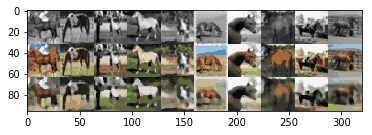

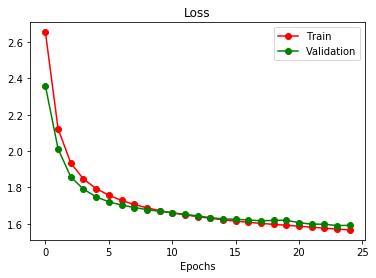

In [9]:
args = AttrDict()
args_dict = {
              'gpu':True, 
              'valid':False, 
              'checkpoint':"", 
              'colours':'./data/colours/colour_kmeans24_cat7.npy', 
              'model':"CNN", 
              'kernel':3,
              'num_filters':32, 
              'learn_rate':0.001, 
              'batch_size':100, 
              'epochs':25, 
              'seed':0,
              'plot':True, 
              'experiment_name': 'colourization_cnn',
              'visualize': False,
              'downsize_input':False,
}
args.update(args_dict)
cnn = train(args)

Q2 b)

* The classification network colorised image outputs are more colorful and realistic. Colors are lively, saturated, and restricted to the regions they belong.

* The regression CNN colorised images were desaturated and appear unpleasing.
 
* Classification network is able to correctly classify the color of a particular pixel more effectively and it is also much more likely to
predict colors that match the saturation levels of images.

## Main training loop for UNet

Loading data...
data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...
Epoch [1/25], Loss: 2.5408, Time (s): 1
Epoch [1/25], Val Loss: 2.1995, Val Acc: 29.0%, Time(s): 1
Epoch [2/25], Loss: 1.9705, Time (s): 2
Epoch [2/25], Val Loss: 1.8724, Val Acc: 35.0%, Time(s): 2
Epoch [3/25], Loss: 1.7905, Time (s): 3
Epoch [3/25], Val Loss: 1.7294, Val Acc: 38.0%, Time(s): 3
Epoch [4/25], Loss: 1.6993, Time (s): 4
Epoch [4/25], Val Loss: 1.6565, Val Acc: 39.0%, Time(s): 5
Epoch [5/25], Loss: 1.6425, Time (s): 6
Epoch [5/25], Val Loss: 1.6134, Val Acc: 41.0%, Time(s): 6
Epoch [6/25], Loss: 1.6020, Time (s): 7
Epoch [6/25], Val Loss: 1.5906, Val Acc: 41.0%, Time(s): 7
Epoch [7/25], Loss: 1.5699, Time (s): 8
Epoch [7/25], Val Loss: 1.5587, Val Acc: 42.0%, Time(s): 8
Epoch [8/25], Loss: 1.5437, Time (s): 9
Epoch [8/25], Val Loss: 1.5378, Val Acc: 42.0%, Time(s): 10
Epoch [9/25], Loss: 1.5213, Time (s): 11
Epoch [9/25], Val Loss: 1.5211, Val Acc: 42.0%, Time(s): 11
Epoch [10/25],

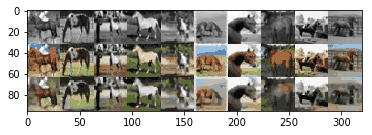

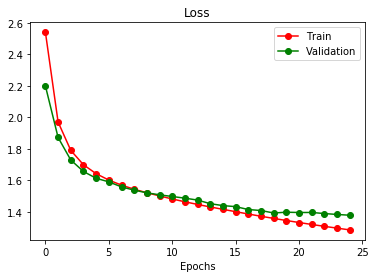

In [10]:
#Batch Size 100
args = AttrDict()
args_dict = {
              'gpu':True, 
              'valid':False, 
              'checkpoint':"", 
              'colours':'./data/colours/colour_kmeans24_cat7.npy', 
              'model':"UNet", 
              'kernel':3,
              'num_filters':32, 
              'learn_rate':0.001, 
              'batch_size':100, 
              'epochs':25, 
              'seed':0,
              'plot':True, 
              'experiment_name': 'colourization_unet',
              'visualize': False,
              'downsize_input':False,
}
args.update(args_dict)
unet_cnn = train(args)

Q3 b)

* When we compare UNet model results with previous CNN model we see that Training and validation loss decreases while training with batch size 100 and num_epochs 25.

* Validation accuracy increases as a result for UNet model and skip connections. The images are crisp and less staurated, thus are of greater quality.

* Information that was captured in the initial layers and was required for reconstruction during the up-sampling. The skip connections stop that information from getting lost. So the information that we had in the primary layers was fed explicitly to the later layers using the skip architecture which tackles the vanishing gradient problem.

* Skip connections eliminate these singularities by breaking the permutation symmetry of nodes, by reducing the possibility of node elimination (deactivation) and by making the nodes less linearly dependent.

* Also, skip connections make sure that the model converges faster.






Loading data...
data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...
Epoch [1/25], Loss: 2.7574, Time (s): 1
Epoch [1/25], Val Loss: 2.7793, Val Acc: 16.0%, Time(s): 1
Epoch [2/25], Loss: 2.2361, Time (s): 2
Epoch [2/25], Val Loss: 2.1387, Val Acc: 31.0%, Time(s): 2
Epoch [3/25], Loss: 1.9787, Time (s): 3
Epoch [3/25], Val Loss: 1.9160, Val Acc: 35.0%, Time(s): 4
Epoch [4/25], Loss: 1.8393, Time (s): 5
Epoch [4/25], Val Loss: 1.8034, Val Acc: 37.0%, Time(s): 5
Epoch [5/25], Loss: 1.7550, Time (s): 6
Epoch [5/25], Val Loss: 1.7360, Val Acc: 38.0%, Time(s): 6
Epoch [6/25], Loss: 1.6957, Time (s): 7
Epoch [6/25], Val Loss: 1.6777, Val Acc: 39.0%, Time(s): 8
Epoch [7/25], Loss: 1.6518, Time (s): 9
Epoch [7/25], Val Loss: 1.6459, Val Acc: 39.0%, Time(s): 9
Epoch [8/25], Loss: 1.6166, Time (s): 10
Epoch [8/25], Val Loss: 1.6121, Val Acc: 40.0%, Time(s): 11
Epoch [9/25], Loss: 1.5896, Time (s): 12
Epoch [9/25], Val Loss: 1.5908, Val Acc: 41.0%, Time(s): 12
Epoch [10/25]

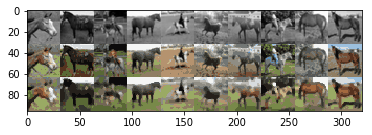

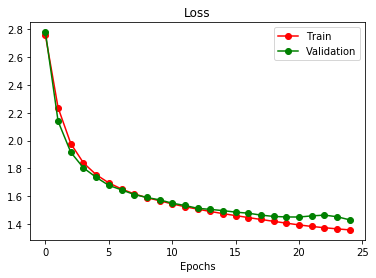

In [11]:
#Q3 c)
#Batch Size 200
args = AttrDict()
args_dict = {
              'gpu':True, 
              'valid':False, 
              'checkpoint':"", 
              'colours':'./data/colours/colour_kmeans24_cat7.npy', 
              'model':"UNet", 
              'kernel':3,
              'num_filters':32, 
              'learn_rate':0.001, 
              'batch_size':200, 
              'epochs':25, 
              'seed':0,
              'plot':True, 
              'experiment_name': 'colourization_unet',
              'visualize': False,
              'downsize_input':False,
}
args.update(args_dict)
unet_cnn = train(args)

Loading data...
data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...
Epoch [1/25], Loss: 2.2794, Time (s): 1
Epoch [1/25], Val Loss: 1.9158, Val Acc: 32.0%, Time(s): 1
Epoch [2/25], Loss: 1.8007, Time (s): 2
Epoch [2/25], Val Loss: 1.6985, Val Acc: 38.0%, Time(s): 2
Epoch [3/25], Loss: 1.6762, Time (s): 3
Epoch [3/25], Val Loss: 1.6128, Val Acc: 40.0%, Time(s): 3
Epoch [4/25], Loss: 1.6099, Time (s): 5
Epoch [4/25], Val Loss: 1.5637, Val Acc: 41.0%, Time(s): 5
Epoch [5/25], Loss: 1.5622, Time (s): 6
Epoch [5/25], Val Loss: 1.5343, Val Acc: 42.0%, Time(s): 6
Epoch [6/25], Loss: 1.5233, Time (s): 7
Epoch [6/25], Val Loss: 1.5079, Val Acc: 43.0%, Time(s): 7
Epoch [7/25], Loss: 1.4897, Time (s): 9
Epoch [7/25], Val Loss: 1.4812, Val Acc: 43.0%, Time(s): 9
Epoch [8/25], Loss: 1.4606, Time (s): 10
Epoch [8/25], Val Loss: 1.4635, Val Acc: 44.0%, Time(s): 10
Epoch [9/25], Loss: 1.4348, Time (s): 11
Epoch [9/25], Val Loss: 1.4461, Val Acc: 44.0%, Time(s): 11
Epoch [10/25]

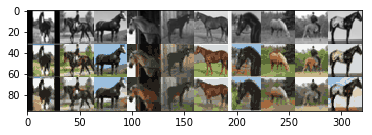

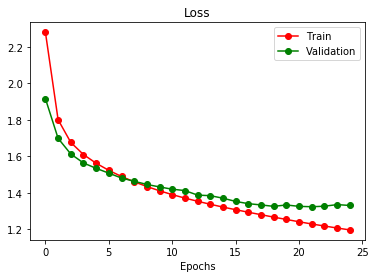

In [12]:
#Q3 c)
#Batch Size 50
args = AttrDict()
args_dict = {
              'gpu':True, 
              'valid':False, 
              'checkpoint':"", 
              'colours':'./data/colours/colour_kmeans24_cat7.npy', 
              'model':"UNet", 
              'kernel':3,
              'num_filters':32, 
              'learn_rate':0.001, 
              'batch_size':50, 
              'epochs':25, 
              'seed':0,
              'plot':True, 
              'experiment_name': 'colourization_unet',
              'visualize': False,
              'downsize_input':False,
}
args.update(args_dict)
unet_cnn = train(args)

Q3 c)

* Increasing the Batch Size to 200 leads to poor results as compared to batch size of 100. Both training and validation losses increase and validation accuracy decreases.

* Decreasing the Batch Size to 50 produces better results as compared to batch size of 100. Training loss decreases to 1.2007, while validation loss remains almost same with batch size 100. This suggests overfitting when we reduce the batch size.

* Final image qualitative output remains almost same and very less differences are visible with change in batch size. 

# CIFAR-10 super-resolution

## Main training loop

Loading data...
data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...


/usr/local/lib/python2.7/dist-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Epoch [1/25], Loss: 2.5078, Time (s): 1
Epoch [1/25], Val Loss: 2.1109, Val Acc: 32.0%, Time(s): 1
Epoch [2/25], Loss: 1.8599, Time (s): 2
Epoch [2/25], Val Loss: 1.7353, Val Acc: 40.0%, Time(s): 2
Epoch [3/25], Loss: 1.6652, Time (s): 3
Epoch [3/25], Val Loss: 1.6260, Val Acc: 43.0%, Time(s): 3
Epoch [4/25], Loss: 1.6027, Time (s): 4
Epoch [4/25], Val Loss: 1.5810, Val Acc: 44.0%, Time(s): 4
Epoch [5/25], Loss: 1.5739, Time (s): 6
Epoch [5/25], Val Loss: 1.5634, Val Acc: 44.0%, Time(s): 6
Epoch [6/25], Loss: 1.5559, Time (s): 7
Epoch [6/25], Val Loss: 1.5497, Val Acc: 44.0%, Time(s): 7
Epoch [7/25], Loss: 1.5422, Time (s): 8
Epoch [7/25], Val Loss: 1.5380, Val Acc: 45.0%, Time(s): 8
Epoch [8/25], Loss: 1.5315, Time (s): 9
Epoch [8/25], Val Loss: 1.5277, Val Acc: 45.0%, Time(s): 10
Epoch [9/25], Loss: 1.5233, Time (s): 11
Epoch [9/25], Val Loss: 1.5233, Val Acc: 45.0%, Time(s): 11
Epoch [10/25], Loss: 1.5164, Time (s): 12
Epoch [10/25], Val Loss: 1.5186, Val Acc: 45.0%, Time(s): 12
Epo

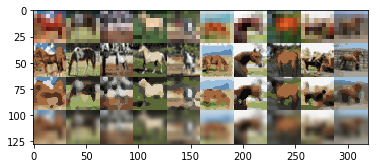

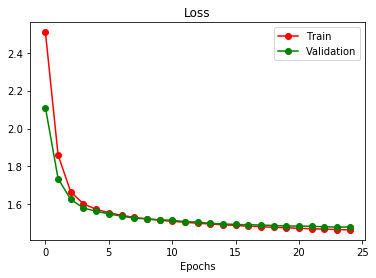

In [13]:
#With CNN
args = AttrDict()
args_dict = {
              'gpu':True, 
              'valid':False, 
              'checkpoint':"", 
              'colours':'./data/colours/colour_kmeans24_cat7.npy', 
              'model':"CNN", 
              'kernel':3,
              'num_filters':32, 
              'learn_rate':0.001, 
              'batch_size':100, 
              'epochs':25, 
              'seed':0,
              'plot':True, 
              'experiment_name': 'super_res_unet',
              'visualize': False,
              'downsize_input':True,
}
args.update(args_dict)
sr_cnn = train(args)

Q4 a) Downsized input image resolution is 32x32 and output image resolution is 32x32.

Loading data...
data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...
Epoch [1/25], Loss: 2.2765, Time (s): 1
Epoch [1/25], Val Loss: 1.9255, Val Acc: 32.0%, Time(s): 1
Epoch [2/25], Loss: 1.7930, Time (s): 2
Epoch [2/25], Val Loss: 1.6974, Val Acc: 38.0%, Time(s): 2
Epoch [3/25], Loss: 1.6738, Time (s): 3
Epoch [3/25], Val Loss: 1.6004, Val Acc: 41.0%, Time(s): 3
Epoch [4/25], Loss: 1.6070, Time (s): 5
Epoch [4/25], Val Loss: 1.5436, Val Acc: 42.0%, Time(s): 5
Epoch [5/25], Loss: 1.5587, Time (s): 6
Epoch [5/25], Val Loss: 1.5049, Val Acc: 43.0%, Time(s): 6
Epoch [6/25], Loss: 1.5199, Time (s): 7
Epoch [6/25], Val Loss: 1.4772, Val Acc: 44.0%, Time(s): 7
Epoch [7/25], Loss: 1.4868, Time (s): 9
Epoch [7/25], Val Loss: 1.4512, Val Acc: 45.0%, Time(s): 9
Epoch [8/25], Loss: 1.4580, Time (s): 10
Epoch [8/25], Val Loss: 1.4306, Val Acc: 46.0%, Time(s): 10
Epoch [9/25], Loss: 1.4326, Time (s): 11
Epoch [9/25], Val Loss: 1.4070, Val Acc: 46.0%, Time(s): 12
Epoch [10/25]

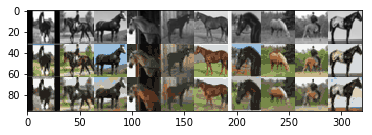

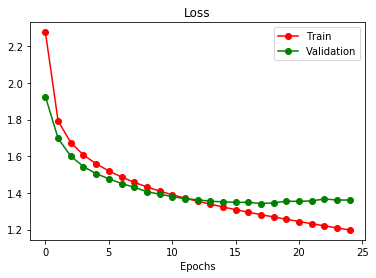

In [15]:
#Q4 b) With UNet

args = AttrDict()
args_dict = {
              'gpu':True, 
              'valid':False, 
              'checkpoint':"", 
              'colours':'./data/colours/colour_kmeans24_cat7.npy', 
              'model':"UNet", 
              'kernel':3,
              'num_filters':32, 
              'learn_rate':0.001, 
              'batch_size':50, 
              'epochs':25, 
              'seed':0,
              'plot':True, 
              'experiment_name': 'colourization_unet',
              'visualize': False,
              'downsize_input':False,
}
args.update(args_dict)
sr_unet = train(args)


* When we ran super-resolution with both CNN and UNet, we observe that for UNet, the training loss reduces to 1.2039 while validation loss increases as the number of epochs increase. While in CNN, the training and validation loss are almost comaparable in terms of value as the num_epochs increase.

* For UNet, the validation loss is range bound as does not vary as much as training loss.

* The validation accuarcy for both the CNN and UNet is almost same in terms of percentage.

* Images in the third row (conv net) are more sharp, non-blurry and resistant to noise whereas images in the fourth row (Bilinear Interpolation) are dull, blurry and noisy.

* Bilinear Interpolation uses a weighted average of the four nearest cell centers. The closer an input cell center is to the output cell center, the higher the influence of its value is on the output cell value. This means that the output value could be different than the nearest input, but is always within the same range of values as the input. Since the values can change, Bilinear is not recommended for categorical data. 

* The problem in the case of scaling the image to a larger size is when there are too many new values to be filled in the image. Bilinear Interpolation tries to make guesses of what the new values should be but this introduces errors in the process which leads to noise, haloing, and artifacts.

* But neural network is capable of generalising, that is being trained on one image and reconstructing another, but the reconstruction is better, when the reconstructed image is the same as the one used for training.

# Visualization

You will run the following code to generate visualization results. The generated images are saved in the file system of this Colab notebook. You can find them by selecting  the "Files" tab on the left side of the screen. 

>  **Files**  →   **CS6360** →   **a2**  →   **outputs**

## Visualize CNN

In [16]:
args = AttrDict()
args_dict = {
              'colours':'./data/colours/colour_kmeans24_cat7.npy', 
              'index':0,
              'experiment_name': 'colourization_cnn',
              'downsize_input':False,
}
args.update(args_dict)
plot_activation(args, cnn)

data/cifar-10-batches-py.tar.gz
visualization results are saved to outputs/colourization_cnn/act0


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:90: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Q5 a)

* Activations in the first few layers depict the corners, edges (horizontal and vertical) of the input image.

* Whereas activations in the last few layers try to identify more complicated features such as shape, intensity, illuminance, sharpness etc.

* Last few layers are more close in terms of similarity to the actual output image.

## Visualize UNet

In [17]:
args = AttrDict()
args_dict = {
              'colours':'./data/colours/colour_kmeans24_cat7.npy', 
              'index':0,
              'experiment_name': 'colourization_unet',
              'downsize_input':False,
}
args.update(args_dict)
plot_activation(args, unet_cnn)

data/cifar-10-batches-py.tar.gz
visualization results are saved to outputs/colourization_unet/act0


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:90: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Q5 b) 

* UNet is able to produce better looking images as compared to the CNN implementation.

* The linear combination using the skip connections is visible in the activations of later layers.

* Last few layers identify both edges, corners as well as complex features like illuminance and intensity.


## Visualize super-resolution

In [18]:
args = AttrDict()
args_dict = {
              'colours':'./data/colours/colour_kmeans24_cat7.npy', 
              'index':0,
              'experiment_name': 'super_res_unet',
              'downsize_input':True,
}
args.update(args_dict)
plot_activation(args, sr_cnn)

data/cifar-10-batches-py.tar.gz
visualization results are saved to outputs/super_res_unet/act0


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:90: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Q5 b)

* In super resolution, the outputs are the restored high-quality images as compared to the other two models.

* The intermediate layers have modified resolutions and level of bluriness which is different in starting layers and ending layers.


Q6) 

a) Some hyperparameters that can be tuned in the above models are :' kernel_size, num_filters, learn_rate, momentum and seed.

 Modifying the learn_rate to 0.005 increases the validation accuracy of the model and decreases the training and validation loss. Thus, learning rate of 0.005 performs better than 0.001

Loading data...
data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...
Epoch [1/25], Loss: 2.3016, Time (s): 1
Epoch [1/25], Val Loss: 2.0060, Val Acc: 30.0%, Time(s): 1
Epoch [2/25], Loss: 1.9054, Time (s): 2
Epoch [2/25], Val Loss: 1.8410, Val Acc: 34.0%, Time(s): 2
Epoch [3/25], Loss: 1.8029, Time (s): 3
Epoch [3/25], Val Loss: 1.7729, Val Acc: 35.0%, Time(s): 3
Epoch [4/25], Loss: 1.7434, Time (s): 4
Epoch [4/25], Val Loss: 1.7160, Val Acc: 37.0%, Time(s): 4
Epoch [5/25], Loss: 1.7049, Time (s): 5
Epoch [5/25], Val Loss: 1.6784, Val Acc: 38.0%, Time(s): 6
Epoch [6/25], Loss: 1.6747, Time (s): 7
Epoch [6/25], Val Loss: 1.6695, Val Acc: 38.0%, Time(s): 7
Epoch [7/25], Loss: 1.6532, Time (s): 8
Epoch [7/25], Val Loss: 1.6483, Val Acc: 39.0%, Time(s): 8
Epoch [8/25], Loss: 1.6359, Time (s): 9
Epoch [8/25], Val Loss: 1.6544, Val Acc: 39.0%, Time(s): 9
Epoch [9/25], Loss: 1.6210, Time (s): 11
Epoch [9/25], Val Loss: 1.6187, Val Acc: 40.0%, Time(s): 11
Epoch [10/25], 

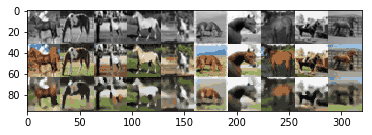

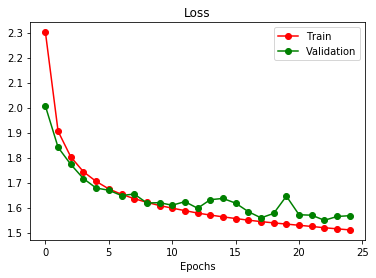

In [19]:
# Learning rate 0.005

args = AttrDict()
args_dict = {
              'gpu':True, 
              'valid':False, 
              'checkpoint':"", 
              'colours':'./data/colours/colour_kmeans24_cat7.npy', 
              'model':"CNN", 
              'kernel':3,
              'num_filters':32, 
              'learn_rate':0.005, 
              'batch_size':100, 
              'epochs':25, 
              'seed':0,
              'plot':True, 
              'experiment_name': 'colourization_cnn',
              'visualize': False,
              'downsize_input':False,
}
args.update(args_dict)
cnn = train(args)

Q6 b)

* The output of RegressionCNN would be same even when we exchange the max pooling and ReLU layer but we can save a lot of running time by putting max pooling layer before the non-linear layers like ReLU.

* The accuracy and loss would remain same, its just the running time that would increase by swithcing both layers.


Q6 c)

* We can improve the evaluation to match with human assessment by using optimized perceptual loss functions based on high-level features extracted from pretrained networks.

* Convolutional neural networks pretrained for image classification have already learned to encode the perceptual and semantic information we would like to measure in our loss functions.

* We can make use of a network which as been pretrained for image classification as a fixed loss network in order to define our loss functions. The deep convolutional transformation network can then trained using loss functions that are also deep convolutional networks

* The loss network can be used to define a feature reconstruction loss  and a style reconstruction loss that measure differences in content and style between the  images.


Q6 d)

We can modify the trained models in this assignment to colourize test images that are larger than 32 × 32 by using the parameter downsize_input = True on the test images. We need to apply same standards on the test images as performed while training.

This would downsample the images to 32x32 (whether training or testing) and then we can execute our model on these images.